Import thư viện

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
import statistics
import random
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import(
    accuracy_score,
    confusion_matrix,
)
import xgboost as xgb

In [3]:
from utils import *

Load dataset

In [4]:
data = pd.read_csv("breast-cancer.data", header=None)
data.columns = ['Class', 'Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad', 'Irradiat']

In [54]:
print_df(data)

                  Class    Age Menopause TumorSize InvNodes NodeCaps  DegMalig Breast BreastQuad Irradiat
0  no-recurrence-events  30-39   premeno     30-34      0-2       no         3   left   left_low       no
1  no-recurrence-events  40-49   premeno     20-24      0-2       no         2  right   right_up       no
2  no-recurrence-events  40-49   premeno     20-24      0-2       no         2   left   left_low       no
3  no-recurrence-events  60-69      ge40     15-19      0-2       no         2  right    left_up       no
4  no-recurrence-events  40-49   premeno       0-4      0-2       no         2  right  right_low       no


Tiền xử lý dữ liệu

In [6]:
encoded_data = data.copy()

label_encoders = {
    'Class': LabelEncoder(),
    'Age': LabelEncoder(),
    'Menopause': LabelEncoder(),
    'DegMalig': LabelEncoder(),
    'Breast': LabelEncoder(),
    'Irradiat': LabelEncoder()
}

for column, encoder in label_encoders.items():
    encoded_data[f'{column}_Encoded'] = encoder.fit_transform(encoded_data[column])

In [7]:
tumor_size_labels = {'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10}
inv_node_labels = {'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '24-26': 6, '27-29': 7}
node_caps_labels = {'yes': 0, 'no': 1}
breast_quad_labels = {'left_up': 0, 'left_low': 1, 'right_up': 2, 'right_low': 3, 'central': 4}

encoded_data['TumorSize_Encoded'] = encoded_data['TumorSize'].map(tumor_size_labels)
encoded_data['InvNodes_Encoded'] = encoded_data['InvNodes'].map(inv_node_labels)
encoded_data['NodeCaps_Encoded'] = encoded_data['NodeCaps'].map(node_caps_labels)
encoded_data['BreastQuad_Encoded'] = encoded_data['BreastQuad'].map(breast_quad_labels)

In [8]:
encoded_data = encoded_data.drop(['Class', 'Age', 'Menopause', 'TumorSize', 'InvNodes', 'NodeCaps', 'DegMalig', 'Breast', 'BreastQuad', 'Irradiat'], axis='columns')

In [9]:
print_missing_data(encoded_data)


Dữ liệu thiếu của các cột:
NodeCaps_Encoded      8
BreastQuad_Encoded    1
dtype: int64


In [10]:
print_rows_with_nan(encoded_data)

     Class_Encoded  Age_Encoded  Menopause_Encoded  DegMalig_Encoded  Breast_Encoded  Irradiat_Encoded  TumorSize_Encoded  InvNodes_Encoded  NodeCaps_Encoded  BreastQuad_Encoded
145              0            2                  2                 1               0                 1                  5                 0               NaN                 3.0
163              0            4                  0                 0               1                 1                  5                 1               NaN                 0.0
164              0            4                  0                 0               1                 1                  5                 1               NaN                 1.0
183              0            3                  0                 2               0                 1                  6                 3               NaN                 0.0
184              0            3                  0                 2               0                 1        

Thay thế 1 giá trị bị thiếu ở BreastQuad bằng 1 giá trị xuất hiện nhiều nhất (mode)

In [11]:
BreastQuad_mode_value = encoded_data['BreastQuad_Encoded'].mode()[0]
encoded_data['BreastQuad_Encoded'] = encoded_data['BreastQuad_Encoded'].fillna(BreastQuad_mode_value)

Xử lý dữ liệu bị thiếu ở cột NodeCaps bằng phương pháp chia dữ liệu thành phần đủ và thiếu, dùng phần đủ dự đoán cho thiếu

In [12]:
full_data = encoded_data[encoded_data['NodeCaps_Encoded'].notna()]
misssing_data = encoded_data[encoded_data['NodeCaps_Encoded'].isna()]
print(f'Số dữ liệu đầy đủ: {len(full_data)}. Số dữ liệu bị thiếu: {len(misssing_data)}')

Số dữ liệu đầy đủ: 278. Số dữ liệu bị thiếu: 8


In [13]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(full_data[['Class_Encoded','Age_Encoded','Menopause_Encoded','DegMalig_Encoded','Breast_Encoded','Irradiat_Encoded','TumorSize_Encoded','InvNodes_Encoded','BreastQuad_Encoded']])

predicted_values = imputer.transform(misssing_data[['Class_Encoded','Age_Encoded','Menopause_Encoded','DegMalig_Encoded','Breast_Encoded','Irradiat_Encoded','TumorSize_Encoded','InvNodes_Encoded','BreastQuad_Encoded']])

misssing_data.loc[:,'NodeCaps_Encoded'] = predicted_values[:, 0]

encoded_data = pd.concat([full_data, misssing_data], ignore_index=True)

Dữ liệu bị thiếu sau khi xử lý:

In [14]:
print(misssing_data.to_string())

     Class_Encoded  Age_Encoded  Menopause_Encoded  DegMalig_Encoded  Breast_Encoded  Irradiat_Encoded  TumorSize_Encoded  InvNodes_Encoded  NodeCaps_Encoded  BreastQuad_Encoded
145              0            2                  2                 1               0                 1                  5                 0               0.0                 3.0
163              0            4                  0                 0               1                 1                  5                 1               0.0                 0.0
164              0            4                  0                 0               1                 1                  5                 1               0.0                 1.0
183              0            3                  0                 2               0                 1                  6                 3               0.0                 0.0
184              0            3                  0                 2               0                 1        

Xáo trộn lại các hàng trong dataframe và cắt 10 dòng đầu tiên dành test

In [15]:
shuffled_df = encoded_data.sample(frac=1).reset_index(drop=True)
df_first_10 = shuffled_df.head(10)
encoded_data = shuffled_df.iloc[10:]

Train mô hình

In [16]:
model_list = []

KNN

In [17]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

results = []

for k_neighbor in range (1,20):
  if k_neighbor % 2 == 0:
     continue
  temp = []
  for each in range(1, 21):
      combined = list(zip(DataX.values, DataY.values))
      random.shuffle(combined)  # Xáo trộn dữ liệu
      Data_X_shuffled, Data_Y_shuffled = zip(*combined)

      trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.2, random_state=42)

      knn_model = KNeighborsClassifier(k_neighbor)

      knn_model.fit(trainX, trainY)

      Y_Pred = knn_model.predict(testX)

      acc = accuracy_score(testY, Y_Pred) * 100
      temp.append(acc)
  result = round(statistics.mean(temp),2)

  #Tính ma trận nhầm lẫn 
  cm = confusion_matrix(testY, Y_Pred)
  results.append({
        'k': k_neighbor,
        'accuracy': result,
        'confusion_matrix': cm,
        'model': knn_model
    })

  print("Trung bình của k = {}: {}%".format(k_neighbor,result))

Trung bình của k = 1: 60.8%
Trung bình của k = 3: 69.38%
Trung bình của k = 5: 69.38%
Trung bình của k = 7: 71.61%
Trung bình của k = 9: 68.12%
Trung bình của k = 11: 68.93%
Trung bình của k = 13: 69.73%
Trung bình của k = 15: 69.46%
Trung bình của k = 17: 69.82%
Trung bình của k = 19: 70.8%


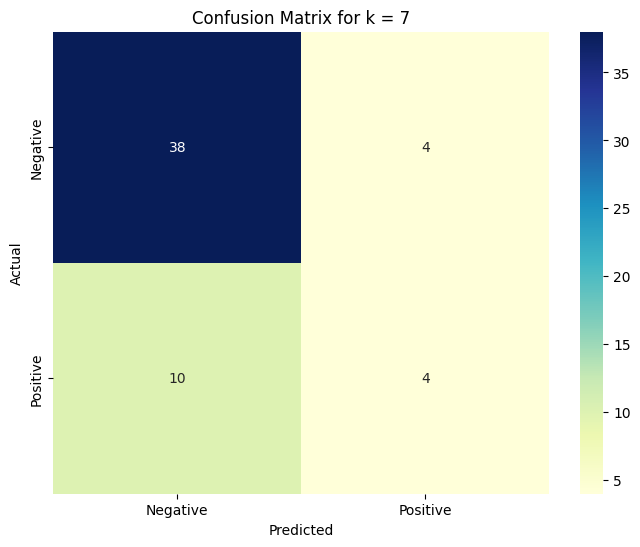

Kết quả tốt nhất: k = 7, Độ chính xác = 71.61%


In [18]:
best_result = max(results, key=lambda x: x['accuracy'])
model_list.append(best_result['model'])
best_cm = best_result['confusion_matrix']

#Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for k = {}'.format(best_result['k']))
plt.show()

print("Kết quả tốt nhất: k = {}, Độ chính xác = {}%".format(best_result['k'], best_result['accuracy']))

Cây quyết định

In [23]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0

best_model = None
total_cm = None
for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    dt_model = DecisionTreeClassifier(random_state=42, min_samples_leaf=2, max_depth=None, min_samples_split=40, criterion='gini')

    dt_model.fit(trainX, trainY)

    Y_Pred = dt_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    print(acc)
    temp.append(acc)
    if best_model is None:
        best_model = dt_model
        best_acc = acc
    elif acc > best_acc:
        best_model = dt_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")
Ketqua_trung_binh = round(statistics.mean(temp),2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

78.57142857142857
64.28571428571429
64.28571428571429
64.28571428571429
67.85714285714286
78.57142857142857
64.28571428571429
75.0
71.42857142857143
64.28571428571429
75.0
71.42857142857143
67.85714285714286
71.42857142857143
82.14285714285714
71.42857142857143
82.14285714285714
75.0
50.0
71.42857142857143
Độ chính xác cao nhất:82.14%
Trung bình: 70.54%


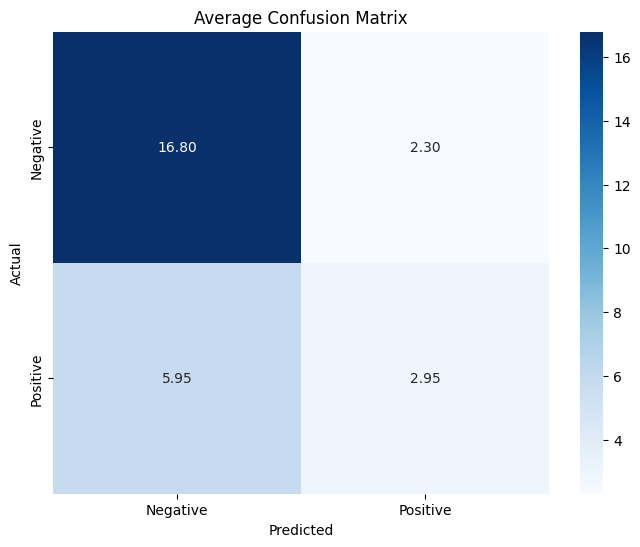

In [24]:
avg_cm = total_cm / 20
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

Bayes

In [27]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0

best_model = None
total_cm = None
for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    bayes_model = GaussianNB(var_smoothing=1e-9)

    bayes_model.fit(trainX, trainY)

    Y_Pred = bayes_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    temp.append(acc)
    if best_model is None:
        best_model = bayes_model
        best_acc = acc
    elif acc > best_acc:
        best_model = bayes_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")
Ketqua_trung_binh = round(statistics.mean(temp),2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

Độ chính xác cao nhất:82.14%
Trung bình: 71.43%


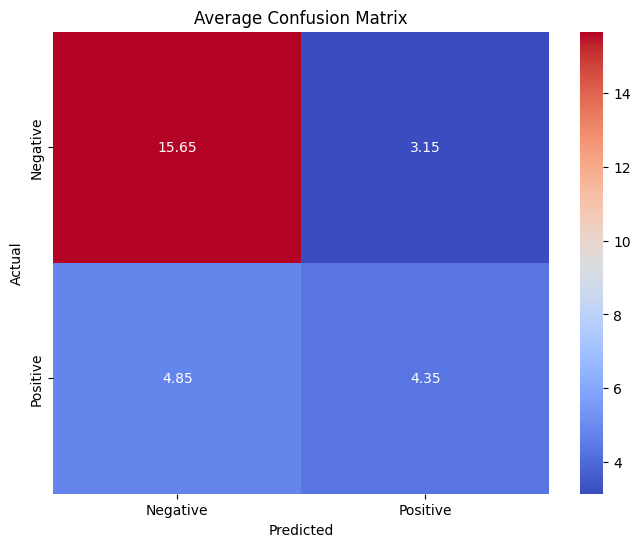

In [28]:
avg_cm = total_cm / 20
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

Bagging

In [29]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0

best_model = None
total_cm = None
for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    base_model = DecisionTreeClassifier(random_state=42, min_samples_leaf=2, max_depth=None, min_samples_split=40, criterion='gini')
    bg_model = BaggingClassifier(estimator=base_model, n_estimators=50, random_state=42)

    bg_model.fit(trainX, trainY)

    Y_Pred = bg_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    temp.append(acc)
    if best_model is None:
        best_model = bg_model
        best_acc = acc
    elif acc > best_acc:
        best_model = bg_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")

Ketqua_trung_binh = round(statistics.mean(temp),2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

Độ chính xác cao nhất:85.71%
Trung bình: 72.32%


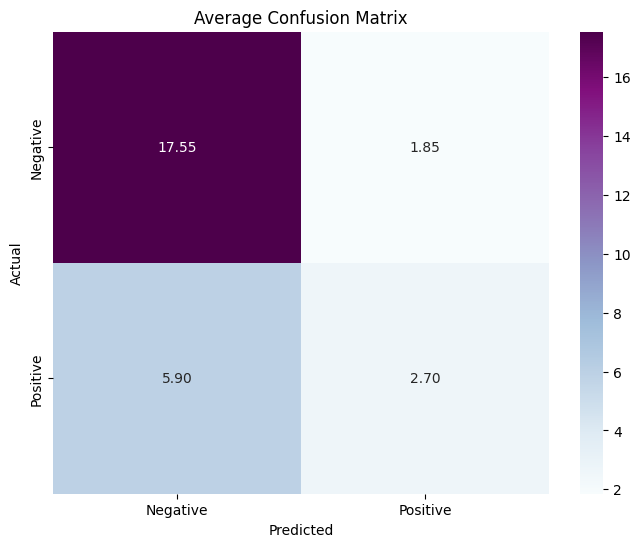

In [30]:
avg_cm = total_cm / 20
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='BuPu', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

Rừng ngẫu nhiên

In [32]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0

best_model = None
total_cm = None
for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=2, bootstrap=True)

    rf_model.fit(trainX, trainY)

    Y_Pred = rf_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    temp.append(acc)
    if best_model is None:
        best_model = rf_model
        best_acc = acc
    elif acc > best_acc:
        best_model = rf_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")
Ketqua_trung_binh = round(statistics.mean(temp),2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

Độ chính xác cao nhất:85.71%
Trung bình: 73.21%


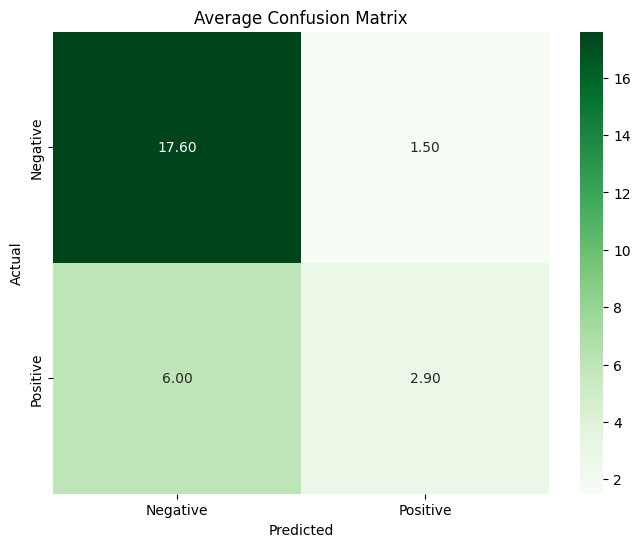

In [33]:
avg_cm = total_cm / 20
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

SVM

In [34]:
df = encoded_data
DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0

best_model = None
total_cm = None
for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    svm_model = SVC(kernel = 'rbf', C = 10000, gamma = 0.01)

    svm_model.fit(trainX, trainY)

    Y_Pred = svm_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    temp.append(acc)
    if best_model is None:
        best_model = svm_model
        best_acc = acc
    elif acc > best_acc:
        best_model = svm_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")

Ketqua_trung_binh = round(statistics.mean(temp),2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

Độ chính xác cao nhất:82.14%
Trung bình: 71.61%


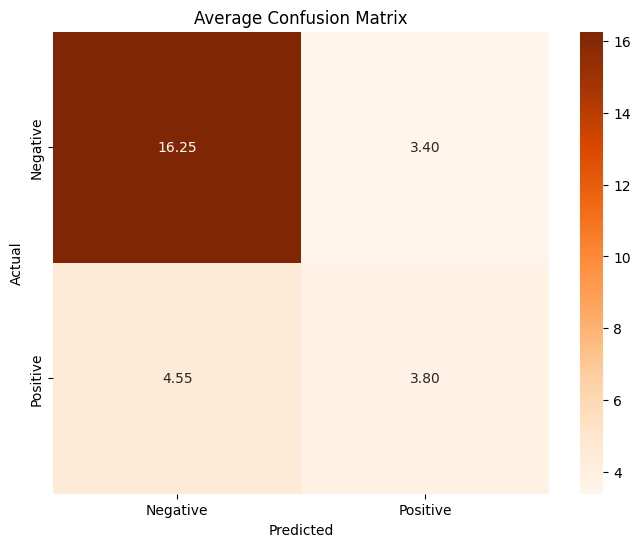

In [35]:
avg_cm = total_cm / 20
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Oranges', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

Extreme Gradient Boosting (XGB)

In [36]:
df = encoded_data

DataX = df.drop('Class_Encoded', axis=1)
DataY = df['Class_Encoded']

temp = []
best_acc = 0
best_model = None
total_cm = None

for each in range(1, 21):
    combined = list(zip(DataX.values, DataY.values))
    random.shuffle(combined)  # Xáo trộn dữ liệu
    Data_X_shuffled, Data_Y_shuffled = zip(*combined)

    trainX, testX, trainY, testY = train_test_split(Data_X_shuffled, Data_Y_shuffled, test_size=0.1, random_state=42)

    xgb_model = xgb.XGBClassifier(eval_metric='logloss',n_estimators=50,learning_rate=0.1,max_depth=None,subsample=0.8,colsample_bytree=0.8)

    xgb_model.fit(trainX, trainY)

    Y_Pred = xgb_model.predict(testX)

    acc = accuracy_score(testY, Y_Pred) * 100
    temp.append(acc)
    if best_model is None or acc > best_acc:
        best_model = xgb_model
        best_acc = acc

    cm = confusion_matrix(testY, Y_Pred)
    if total_cm is None:
        total_cm = cm
    else:
        total_cm += cm 
print(f"Độ chính xác cao nhất:{best_acc:.2f}%")

Ketqua_trung_binh = round(statistics.mean(temp), 2)
print(f"Trung bình: {Ketqua_trung_binh}%")

model_list.append(best_model)

Độ chính xác cao nhất:89.29%
Trung bình: 75.0%


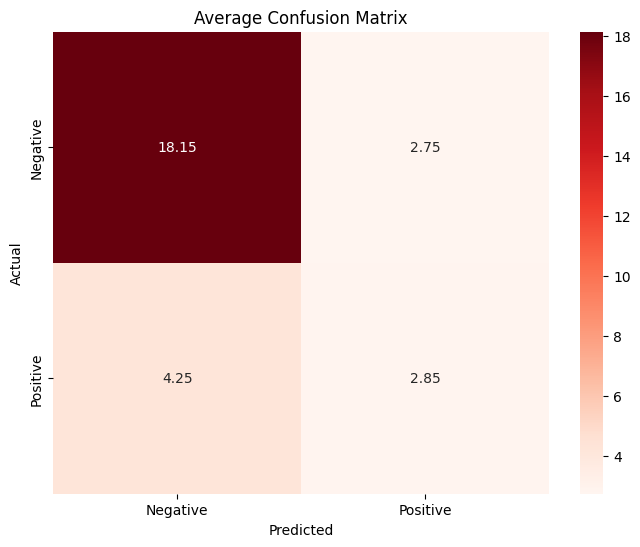

In [37]:
avg_cm = total_cm / 20

plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Average Confusion Matrix')
plt.show()

In [80]:
model_list

[KNeighborsClassifier(n_neighbors=13),
 DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=40,
                        random_state=42),
 GaussianNB(),
 BaggingClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=2,
                                                    min_samples_split=40,
                                                    random_state=42),
                   n_estimators=50, random_state=42),
 RandomForestClassifier(min_samples_leaf=2, n_estimators=1000, random_state=42),
 SVC(C=10000, gamma=0.01),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_bin=None, max_cat_thresh

In [81]:
file_names = ['knn','dt','bayes','bg','rf','svm','xgb']

for i, model in enumerate(model_list):
    file_name = 'model/' + file_names[i] + '.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)
    print(f"Mô hình {file_names[i]} đã được lưu vào {file_name}")

Mô hình knn đã được lưu vào model/knn.pkl
Mô hình dt đã được lưu vào model/dt.pkl
Mô hình bayes đã được lưu vào model/bayes.pkl
Mô hình bg đã được lưu vào model/bg.pkl
Mô hình rf đã được lưu vào model/rf.pkl
Mô hình svm đã được lưu vào model/svm.pkl
Mô hình xgb đã được lưu vào model/xgb.pkl


Test

In [84]:
results = {}

X = df_first_10.drop('Class_Encoded', axis=1)
y = df_first_10['Class_Encoded']


for model in model_list:
    predictions = model.predict(X.to_numpy()) 
    results[type(model).__name__] = predictions


for model_name, preds in results.items():
    print(f"{model_name}: {preds}")

df_results = pd.DataFrame(results)
final_predictions = df_results.mode(axis=1)[0]
final_predictions = final_predictions.to_numpy()

print(f"Đáp án thực tế: {y.to_numpy()}")
print(f"Đáp án tính ra: {final_predictions}")

KNeighborsClassifier: [0 0 1 0 0 1 0 0 0 0]
DecisionTreeClassifier: [0 1 0 0 0 1 0 1 0 0]
GaussianNB: [0 1 0 0 0 0 0 1 0 1]
BaggingClassifier: [0 1 0 0 0 0 0 1 0 0]
RandomForestClassifier: [0 1 0 0 0 0 0 1 0 0]
SVC: [0 1 1 0 0 0 0 0 0 0]
XGBClassifier: [0 1 1 0 0 1 0 1 0 0]
Đáp án thực tế: [0 1 0 0 0 0 0 0 0 1]
Đáp án tính ra: [0 1 0 0 0 0 0 1 0 0]
